In [36]:
import sys; sys.path.insert(0, '..')

In [37]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
import pandas as pd
import networkx as nx
import subprocess
import itertools as it
from ast import literal_eval
from src import graph, uniswap

In [38]:
G = nx.DiGraph()
edges = [
    ('v1', 'v2', -1),
    ('v2', 'v3', 2),
    ('v3', 'v4', 2),
    ('v4', 'v2', 1),
    ('v1', 'v3', 4),
    ('v1', 'v4', 7),
    # Additional vertices and edges
    ('v2', 'v5', 3),
    ('v5', 'v6', -2),
    ('v6', 'v3', 1),
    ('v5', 'v7', 5),
    ('v7', 'v4', -3),
    ('v6', 'v7', 2),
    ('v3', 'v8', 6),
    ('v8', 'v1', -4),
    ('v8', 'v5', 1)
]

for u, v, w in edges:
    G.add_edge(u, v, weight=w)

len(G.edges), len(G.nodes)


(15, 8)

In [39]:
print(edges)

[('v1', 'v2', -1), ('v2', 'v3', 2), ('v3', 'v4', 2), ('v4', 'v2', 1), ('v1', 'v3', 4), ('v1', 'v4', 7), ('v2', 'v5', 3), ('v5', 'v6', -2), ('v6', 'v3', 1), ('v5', 'v7', 5), ('v7', 'v4', -3), ('v6', 'v7', 2), ('v3', 'v8', 6), ('v8', 'v1', -4), ('v8', 'v5', 1)]


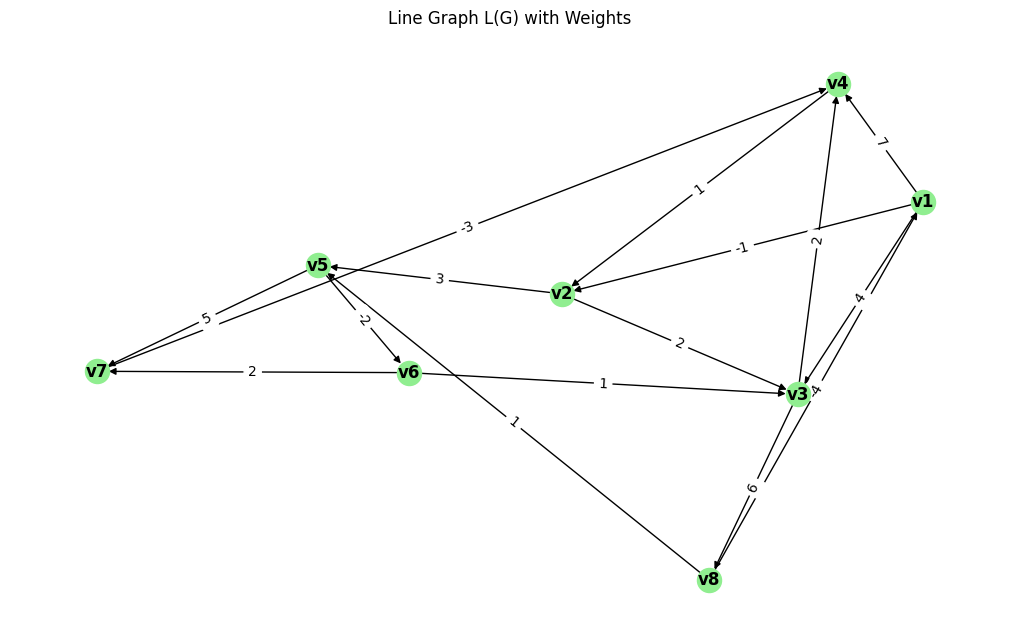

In [40]:
edge_labels_LG = nx.get_edge_attributes(G, 'weight')

pos_LG = nx.spring_layout(G)  # Position for the line graph nodes
plt.figure(figsize=(10, 6))
nx.draw(G, pos_LG, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
nx.draw_networkx_edge_labels(G, pos_LG, edge_labels=edge_labels_LG, font_color='black')
plt.title("Line Graph L(G) with Weights")
plt.show()


In [41]:
def modified_moore_bellman_ford(G, source):
     
     G_cop = G.copy()
     G_cop.add_edge('O', source, weight=0)

     
     # Create line graph L(G) with weights as in the paper
     L_G = nx.DiGraph()
     for u, v in G_cop.edges():
          for w in G_cop.successors(v):
               L_G.add_edge((u, v), (v, w), weight=G[v][w]['weight'])

     distances = {node: float('inf') for node in L_G.nodes()}
     paths = {node: [] for node in L_G.nodes()}

     distances[('O', source)] = 0

     for _ in range(len(G_cop.nodes) - 1):
          for (v_i, v_j), (v_j2, v_l) in L_G.edges():
               weight = L_G[(v_i, v_j)][(v_j2, v_l)]['weight']
               flat_nodes = [node for pair in paths[(v_i, v_j)] for node in pair]
               if distances[(v_i, v_j)] + weight < distances[(v_j2, v_l)]:
                    if v_l not in flat_nodes or v_l == source:
                         distances[(v_j2, v_l)] = distances[(v_i, v_j)] + weight
                         paths[(v_j2, v_l)] = paths[(v_i, v_j)] + [(v_j2, v_l)]

     D_token = {node: float('inf') for node in G_cop.nodes()}
     P_token = {}
     for (v_i, v_j) in distances:
          v_d = distances[(v_i, v_j)]
          t = v_j
          if v_d < D_token[t]:
               D_token[t] = v_d
               P_token[t] = paths[(v_i, v_j)]
     return P_token, D_token  


In [42]:
def bfs_distances(G, source):
    bfs_paths = {source: [source]}
    distances = {source: 0}
    for parent, child in nx.bfs_edges(G, source=source):
        # Path to child is path to parent + [child]
        bfs_paths[child] = bfs_paths[parent] + [child]
        # Distance to child is distance to parent + edge weight
        distances[child] = distances[parent] + G[parent][child]['weight']

    return bfs_paths, distances 


In [43]:
source = 'v1'
mmmbf_paths, mmmbf_distances = modified_moore_bellman_ford(G, source)
bf_paths, bf_distances = nx.bellman_ford_predecessor_and_distance(G, source)
bfs_paths, bfs_distances = bfs_distances(G, source)

In [44]:
# Compare the distances calculated by each algorithm for all nodes
comparison_df = pd.DataFrame({
    'BFS': bfs_distances,
    'Modified Moore-Bellman-Ford': mmmbf_distances,
    'Bellman-Ford': bf_distances
})

print(comparison_df)

     BFS  Modified Moore-Bellman-Ford  Bellman-Ford
v1   0.0                          0.0           0.0
v2  -1.0                         -1.0          -1.0
v3   4.0                          1.0           1.0
v4   7.0                         -1.0          -1.0
v5   2.0                          2.0           2.0
v8  10.0                          7.0           7.0
v6   0.0                          0.0           0.0
v7   7.0                          2.0           2.0
O    NaN                          inf           NaN
